# A brief look at the Slovenia 2023 Floods

In this project we briefly examine the floods that took place in Slovenia in early August, by using Python 3 + some libraries.
We use a government-provided open-source dataset ([source](https://podatki.gov.si/dataset/opozorilna-karta-poplav)) to mark areas of Slovenia, that are more exposed to flooding than other areas. We have 3 levels of severity:
1. commonly flooded areas
2. rarely flooded areas
3. very rarely flooded areas

The details, for how these areas are designated, are specified in the source, and aren't that relevant to us.

## Fetching data

To <b>fetch</b> our required dataset, we use the <em>requests</em> library. The code looks something like this:

In [13]:
import requests
data = requests.get("https://www.statika.evode.gov.si/fileadmin/vodkat/DRSV_OPKP_ZR_POPL.zip", verify=False)
wiki_html = requests.get("https://en.wikipedia.org/wiki/2023_Slovenia_floods")

/home/jan/python/jungle/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.statika.evode.gov.si'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Unfortunately, the government site that stores this dataset has an expired certificate. Hence the warnings we get from calling our GET requests.

This initial request gives us a .zip file, from which we then extract 2 files:
1. <em>some_file.shp</em>, a shapefile which contains geospatial data, that we can later represent on the map
2. <em>some_file.shx</em>, a complementary shape index file, which we need for our shapefile to run correctly

Collecting these shapefiles looks something like this: (note that the code snippet will not run, as I am ommiting some things)

In [14]:
try:
    with ZipFile(file_name + ".zip") as zip:
        with zip.open(file_name + ".shx") as shapefile:
            with open(file_name + ".shx", "wb") as F:
                res = F.write(shapefile.read())
        with zip.open(file_name + ".shp") as shapefile:
            with open(file_name + ".shp", "wb") as F:
                res = F.write(shapefile.read())
except NameError:
    print("It's just an example!")

It's just an example!


## Analysing wiki data

Once we have successfully downloaded our shapefiles, we can move on to the <b>analysis</b> part of the project.

To get more info about the floods, we web-scrape the wikipedia article for the said event (which can be found [here](https://en.wikipedia.org/wiki/2023_Slovenia_floods)). For this, we use the BeautifulSoup library.

In [15]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(wiki_html.content, 'html.parser')

We can use BeautifulSoup to extract relevant data from the Wiki article, like the title for example:

In [16]:
title_element = soup.find("caption", class_="infobox-title")
title = title_element.string
title

'2023 Slovenia floods'

The rest of the scraping looks like this:

In [17]:
date_element = soup.find('th', string="Date").parent
date = date_element.td.string

location_element = soup.find('th', string="Location").parent
locations = [location.string for location in location_element.find_all('a')]

deaths_element = soup.find('th', string="Deaths").parent
deaths = deaths_element.td.string

We can conveniently store all our data in an object, as we have created a FloodData class on the side, that collects all our flood data.

In [18]:
from flood_data import FloodData
flood_data = FloodData(title, date, locations, deaths)
print(flood_data) # we have defined a __repr__() dunder method, for easier object printing

2023 Slovenia floods, 3 August 2023 – 23 August 2023


We also take a look at the sizes of our shapefiles with the following code:

In [19]:
import os.path

common_size = os.path.getsize("DRSV_OPKP_POGOSTE_POPL.shp")
rare_size = os.path.getsize("DRSV_OPKP_REDKE_POPL.shp")
very_rare_size = os.path.getsize("DRSV_OPKP_ZR_POPL.shp")

print(common_size, rare_size, very_rare_size)

1256828 9915832 23562404


We notice, that the common floods shapefile is the smallest, and the very rare floods shapefile is the largest.
This makes sense, if we think of our shapefiles as sets of objects, and the common floods set is (we would think) a subset of the very rare floods. Meaning: the very rare floods shapefile should be covering the areas, that are flooded very rarely, and also areas that are rarely flooded and commonly flooded.

## Analysing historical weather data 

Now we can analyse historical weather data of the 4 most affected regions (whose names we fetched from the wiki).
For convenience, the data for these regions has already been fetched seperately, through the `get_weather_data.py` script.

This data is fetched from a company called Oikolab, who offers historical weather data for free (for a limited amount of units).
We have to tell them 3 essential things in each request: 
1. from where we want data,
2. from what time period we want data,
3. which types of data we want (temperature, rainfall, solar radiation, etc...)

Here are the parameters, we send to Oikolab:

In [20]:
def generic_params(location: str):
    return {
        'param': ['temperature', 'wind_speed', 'surface_solar_radiation', 'total_precipitation'],
        'location': location,
        'start': '2023-08-03',
        'end': '2023-08-06'
    }

TLDR: We get temperature, wind speed, solar radiation, total precipitation, from 3rd August to 6th August, for a location that we pass in.

Once we get the data through a http GET request, we save it in a JSON file, which we can conveniently open in other python files.

In [21]:
from historical_weather_data import HistoricalWeatherData

def handle_historical_weather_data(location, evaled_file) -> HistoricalWeatherData:
    data = evaled_file['data']
    
    temp = []
    wind = []
    solar = []
    rain = []
    
    for entry in data:
        # an entry looks like this: 
        # coords, model name, model elevation, utc offset, temp, wind speed, solar radiation, precipitation

        temp.append(entry[4])
        wind.append(entry[5])
        solar.append(entry[6])
        rain.append(entry[7])

    return HistoricalWeatherData(location, temp, wind, solar, rain)

carinthia_historical = None

with open('fetched_weather_data/carinthia.json', 'r') as F:
    evaled_file = eval(F.read())
    carinthia_historical = handle_historical_weather_data('Carinthia', evaled_file)
with open('fetched_weather_data/carniola.json', 'r') as F:
    evaled_file = eval(F.read())
    carniola_historical = handle_historical_weather_data('Carniola', evaled_file)

with open('fetched_weather_data/littoral.json', 'r') as F:
    evaled_file = eval(F.read())
    littoral_historical = handle_historical_weather_data('Slovene Littoral', evaled_file)

with open('fetched_weather_data/styria.json', 'r') as F:
    evaled_file = eval(F.read())
    styria_historical = handle_historical_weather_data('Styria', evaled_file)

From the function `handle_historical_weather_data()`, we get a neatly packaged HistoricalWeatherData object, that contains our weather data.
By calling `report()` on the HistoricalWeatherData, we get a 'report' printed out, that shows some analyzed data of the weather.

In [22]:
max_precipitations = []

max_precipitations.append(carinthia_historical.report())
max_precipitations.append(carniola_historical.report())
max_precipitations.append(littoral_historical.report())
max_precipitations.append(styria_historical.report())

current_max = [0, "foo"]
for entry in max_precipitations:
    if entry[0] > current_max[0]:
        current_max = entry

print("\nThe region with the heaviest rainfall was {}\n".format(current_max[1]))


WEATHER REPORT FOR Carinthia

Largest reached temperature: 25.04 Celsius
Minimum reached temperature: 12.14 Celsius
Mean temperature: 16.85 Celsius

Largest reached wind speed: 4.22 m/s

Mean radiation: 105.69 Watt / metres squared

Largest reached precipitation: 3.53 mm
Mean precipitation: 1.0 mm

WEATHER REPORT FOR Carniola

Largest reached temperature: 24.64 Celsius
Minimum reached temperature: 11.21 Celsius
Mean temperature: 16.31 Celsius

Largest reached wind speed: 2.93 m/s

Mean radiation: 110.81 Watt / metres squared

Largest reached precipitation: 4.68 mm
Mean precipitation: 1.15 mm

WEATHER REPORT FOR Slovene Littoral

Largest reached temperature: 27.97 Celsius
Minimum reached temperature: 18.87 Celsius
Mean temperature: 22.45 Celsius

Largest reached wind speed: 9.07 m/s

Mean radiation: 179.24 Watt / metres squared

Largest reached precipitation: 8.03 mm
Mean precipitation: 1.32 mm

WEATHER REPORT FOR Styria

Largest reached temperature: 26.02 Celsius
Minimum reached tempe

## Displaying data

We are now ready to <b>display</b> our data. We would like to draw some maps, and that we can achieve by using the <em>geopandas</em> library. The <em>geopandas</em> library uses <em>matplotlib</em> underneath for plotting, so we will be doing some imports to adjust that part as well.

<Axes: title={'center': '3 August 2023 – 23 August 2023'}>

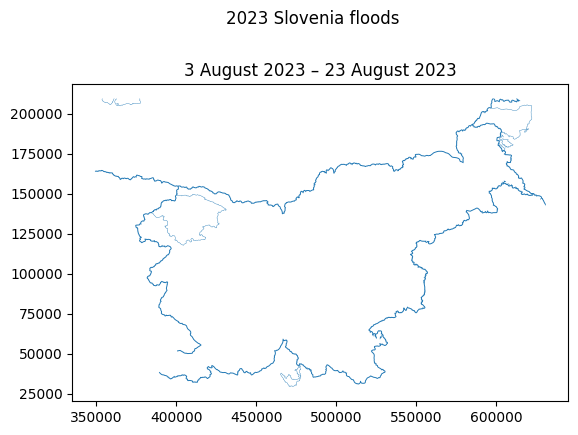

In [23]:
import geopandas
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

fig.suptitle(flood_data.title)
plt.title(flood_data.date)

slovenia = geopandas.read_file("assets/P250V7000_pF.shp")
slovenia.plot(ax=ax)

Notice how we reference our flood data object here, in which we stored relevant info about the flood.
So far we have only drawn an outline of Slovenia, the source for this shapefile is [here](https://ipi.eprostor.gov.si/jgp/data). Obtaining this file via code would be too much of a hassle, so it is already included in the project.

Lets add one layer of flood areas, the very rarely flooded areas.

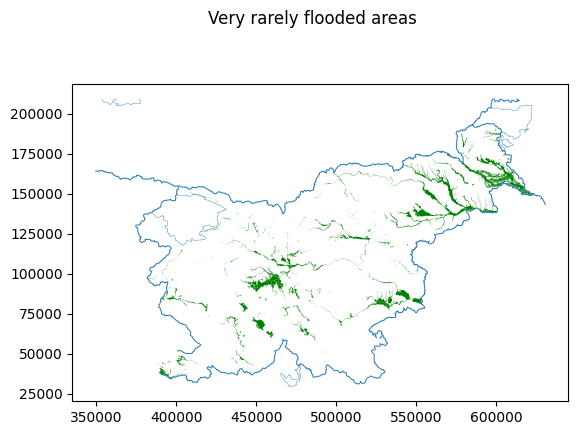

In [24]:
fig, ax = plt.subplots()

fig.suptitle("Very rarely flooded areas")

slovenia = geopandas.read_file("assets/P250V7000_pF.shp")
slovenia.plot(ax=ax)

very_rare = geopandas.read_file("DRSV_OPKP_ZR_POPL.shp")
line = very_rare.plot(ax=ax, color="green", zorder=0)

At this moment we should also examine, what areas were actually flooded in the 2023 floods, as the upper graph only shows areas that are very rarely flooded. From our wiki web-scraping, we have:

In [25]:
flood_data.format_locations()

'Slovene Littoral | Upper Carniola | Carinthia | Styria'

Some helpful translations:
- Slovene Littoral - Primorska
- Upper Carniola - Gorenjska
- Carinthia - Koroška
- Styria - Štajerska

We do see that there are matches in Primorska and Štajerska, where we have marked historical areas of very rare floods, and the areas were actually flooded in the 2023 floods, but not so much for Gorenjska and Koroška. These two regions should come as more of a suprise that they were intensely flooded in the said floods.

By taking a look at <em>[this flood map](assets/flood_map.pdf)</em>, we can see, that these two regions suffered from heavier rain than other regions. This would explain the flooding that took place there, despite the fact that historically, we would not mark these areas as 'commonly flooded'.

Now let's end with a plot, that shows all the three areas of flood severity all at once:

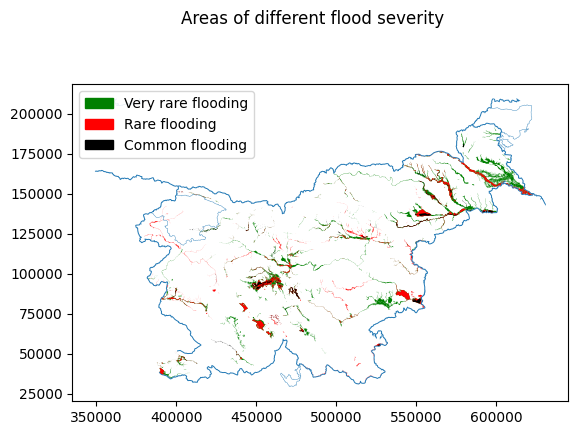

In [26]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots()

fig.suptitle('Areas of different flood severity')

slovenia = geopandas.read_file("assets/P250V7000_pF.shp")
slovenia.plot(ax=ax)

very_rare = geopandas.read_file("DRSV_OPKP_ZR_POPL.shp")
line = very_rare.plot(ax=ax, color="green", zorder=0)

rare = geopandas.read_file("DRSV_OPKP_REDKE_POPL.shp")
rare.plot(ax=ax, color="red", zorder=1)

common = geopandas.read_file("DRSV_OPKP_POGOSTE_POPL.shp")
common.plot(ax=ax, color="black", zorder=2)

very_rare_patch = mpatches.Patch(color='green', label='Very rare flooding')
rare_patch = mpatches.Patch(color='red', label='Rare flooding')
common_patch = mpatches.Patch(color='black', label='Common flooding')
ax.legend(handles=[very_rare_patch, rare_patch, common_patch], loc="upper left")

We can see that Štajerska, Prekmurje and Ljubljanska kotlina seem to have the most areas, that are under the threat of being flooded. However the areas affected in the 2023 floods are not a one-to-one match with our model of threatened areas, so we see that there will be discrepancies with such floods, that depend on where exactly it rained, and how much it rained in each individual region.